# Geometric multigrid solvers

In addition to the full gamut of algebraic solvers offered by PETSc, Firedrake also provides access to multilevel solvers with geometric hierarchies. In this tutorial, we will study strategies to solve the Stokes equations, demonstrating how the multigrid functionality composes with fieldsplit preconditioning.


## Creating a geometric hierarchy

Geometric multigrid requires a geometric hierarchy of meshes on which the equations will be discretised.  For now, Firedrake supports hierarchies of *regularly refined* meshes, which we create by providing a *coarse mesh* and building a `MeshHierarchy`.  This hierarchy encapsulates the relationship between coarse and fine cells.

In [1]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window
%matplotlib widget
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 4)

In [2]:
from firedrake import *

coarse_mesh = RectangleMesh(15, 10, 1.5, 1)

Having made the coarse mesh, we create the hierarchy of meshes.  The second argument tells Firedrake how many levels of refinement to use.  Here we refine three times, so that in total we have four meshes.

In [3]:
hierarchy = MeshHierarchy(coarse_mesh, 3)

The `hierarchy` object behaves like a Python *iterable*, so we can ask for its length and index it to extract meshes on a given level in the normal way:

In [4]:
len(hierarchy)

4

In [5]:
finest_mesh = hierarchy[-1]

### Grid transfer

If you want to control all aspects of the multigrid cycle, Firedrake offers the necessary building blocks.  You just need to create the relevant objects on the levels of the mesh hierarchy, and then use provided functions to transfer information between levels.

Firedrake provides the three functions, `prolong`, `restrict`, and `inject`.

- `prolong` transfers primal quantities from coarse to fine meshes.
- `restrict` transfers dual quantities (residuals) from fine to coarse meshes.  It is the dual of `prolong`.
- `inject` transfers primal quantities from fine to coarse meshes.

Most of the time, there is no need to access the interface at this level.  Instead, it suffices to define the variational problem on the finest level of a mesh hierarchy and then drive the solver using PETSc options.  This is the most flexible method, which we now demonstrate.

## Exercise

Create mesh hierarchy of two levels on an interval mesh.  Create a piecewise linear function on the fine mesh and interpolate the function $f(x) = x$.  Now use the grid transfer functionality to move this function to the coarse mesh (using both `restrict` and `inject`).  Do you notice a difference between the two outcomes?

- Hint 1: You will need to create a `FunctionSpace` on both the coarse and fine mesh.
- Hint 2: use `x, = SpatialCoordinate(mesh)` to gain access to the `x` coordinate on a given mesh.

## Problem setup

We will solve the Stokes equations on a rectangular domain $\Omega = [0, 1.5] \times [0, 1]$.  With constant inflow and outflow through two "pipes" and no slip boundaries everywhere else.

Our problem is to find $(u, p) \in V\times Q$ such that:

$$
\begin{align}
-\nu \nabla^2 u + \nabla p &= 0 \quad \text{in $\Omega$},\\
\nabla \cdot u &= 0 \quad \text{in $\Omega$},\\
u &= u_0 \quad \text{on $\Gamma_{\text{inout}}$},\\
u &= (0, 0) \quad \text{on $\Gamma \setminus \Gamma_{\text{inout}}$},
\end{align}
$$
where 
$$
\Gamma_\text{inout}(x, y) = \{(x, y)\, |\, y \in [1/6, 1/3] \cup [2/3, 5/6], x \in \{0, 1.5\} \}
$$
and
$$
u_0(x, y) = \bigg\{\
\begin{split} 
1 - (12 (y - 1/4))^2 \quad y &< 1/2, \\
1 - (12 (y - 3/4))^2 \quad y &> 1/2. \\
\end{split}
$$

We will use Taylor-Hood elements.  In the usual way, we multiply by test functions and after integrating by parts and incorporating boundary conditions, we arrive at the weak formulation, find $(u, p) \in V \times Q$ such that

$$
\begin{align}
\int_\Omega \nu \nabla u : \nabla v - p\nabla \cdot v\,\text{d}x &= 0 \quad \forall v \in V,\\
\int_\Omega q \nabla \cdot u\,\text{d}x &= 0 \quad \forall q \in Q, \\
u &= (1, 0) \quad \text{on $\Gamma_{\text{inout}}$},\\
u &= (0, 0) \quad \text{on $\Gamma \setminus \Gamma_{\text{inout}}$}.
\end{align}
$$

## Implementation

To make things easier to play with, we'll wrap everything up in a function that we can call to produce a solver.

In [6]:
def create_solver(parameters=None):
    coarse_mesh = RectangleMesh(15, 10, 1.5, 1)
    hierarchy = MeshHierarchy(coarse_mesh, 3)
    
    mesh = hierarchy[-1]
    
    V = VectorFunctionSpace(mesh, "Lagrange", 2)
    Q = FunctionSpace(mesh, "Lagrange", 1)
    W = V*Q
    
    u, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    
    nu = Constant(1)
    x, y = SpatialCoordinate(mesh)
    
    t = conditional(y < 0.5, y - 1/4, y - 3/4)
    gbar = conditional(Or(And(1/6 < y,
                              y < 1/3),
                          And(2/3 < y,
                              y < 5/6)),
                       1, 
                       0)

    value = as_vector([gbar*(1 - (12*t)**2), 0])
    bcs = [DirichletBC(W.sub(0), assemble(interpolate(value, V)), (1, 2)),
           DirichletBC(W.sub(0), zero(2), (3, 4))]
    
    a = (nu*inner(grad(u), grad(v)) - p*div(v) + q*div(u))*dx
    L = inner(Constant((0, 0)), v)*dx
    wh = Function(W)
    problem = LinearVariationalProblem(a, L, wh, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=parameters, appctx={"nu": nu})
    return solver

In [7]:
solver = create_solver({"ksp_type": "preonly",
                        "pc_type": "lu",
                        "pc_factor_shift_type": "inblocks",
                        "ksp_monitor": None,
                        "pmat_type": "aij"})
solver.solve()

    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 1.021257383821e+01 
    1 KSP Residual norm 6.404133272505e-12 


We can extract the solution variable from the solver object and plot the velocity and pressure fields.
In previous notebooks, we've seen how to create multiple subplots, arrange them within a figure, share the axes, set the aspect ratio, and add titles.
Here we're also taking the output of each plotting function -- a set of streamlines from streamplot and a set of colored triangles from tripcolor -- and using them to add a colorbar to each subplot.
When we create the colorbar, we also need to tell matplotlib which axis to draw it on.
Finally, we're adjusting the size and spacing of the colorbar to make the result look nicer.
Steps like this often require some trial and error, but they're essential for making publication-quality figures.

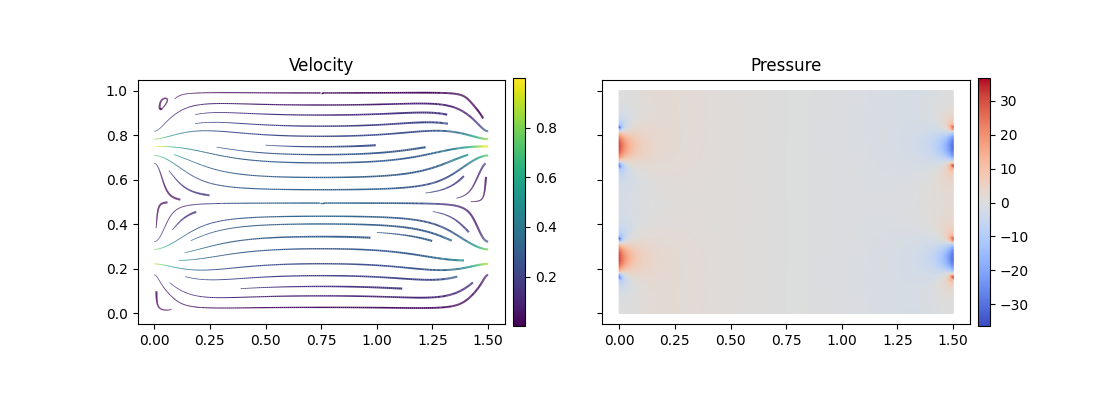

In [8]:
# NBVAL_IGNORE_OUTPUT
from firedrake.pyplot import streamplot, tripcolor

w = solver._problem.u
u, p = w.subfunctions
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
streamlines = streamplot(u, resolution=1/30, seed=4, axes=axes[0])
axes[0].set_aspect("equal")
axes[0].set_title("Velocity")
fig.colorbar(streamlines, ax=axes[0], fraction=0.032, pad=0.02)

triangles = tripcolor(p, axes=axes[1], cmap='coolwarm')
axes[1].set_aspect("equal")
axes[1].set_title("Pressure")
fig.colorbar(triangles, ax=axes[1], fraction=0.032, pad=0.02);

This direct method is not a scalable solution technique for large problems.  Similar to our earlier example involving the mixed Poisson problem, a Schur complement method can be more efficient.  We'll use geometric multigrid to invert the elliptic velocity block, and use a viscosity-weighted pressure mass matrix to precondition the Schur complement.  This gives good results as long as viscosity contrasts are not too strong. The Python preconditioner that we use to create the mass matrix is described in more detail in the composable solvers notebook.

In [9]:
class MassMatrix(AuxiliaryOperatorPC):
    def form(self, pc, test, trial):
        # Grab the viscosity
        nu = self.get_appctx(pc)["nu"]
        return (nu*test*trial*dx, None)

In [10]:
parameters = {
    "ksp_type": "gmres",
    "ksp_monitor": None,
    "pc_type": "fieldsplit",
    "pc_use_amat": True,
    "pc_fieldsplit_type": "schur",
    "pc_fieldsplit_schur_fact_type": "lower",
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "mg",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_pc_type": "python",
    "fieldsplit_1_pc_python_type": "__main__.MassMatrix",
    "fieldsplit_1_aux_pc_type": "icc",
}

solver = create_solver(parameters)
solver.solve()

    Residual norms for firedrake_2_ solve.
    0 KSP Residual norm 1.793015736715e+02 
    1 KSP Residual norm 8.716276054615e+01 
    2 KSP Residual norm 1.669109319703e+01 
    3 KSP Residual norm 1.123132759507e+01 
    4 KSP Residual norm 5.140215836973e+00 
    5 KSP Residual norm 2.860823020181e+00 
    6 KSP Residual norm 1.241682759464e+00 
    7 KSP Residual norm 7.188188009066e-01 
    8 KSP Residual norm 4.044004541226e-01 
    9 KSP Residual norm 1.795717211991e-01 
   10 KSP Residual norm 1.184207774231e-01 
   11 KSP Residual norm 7.266399169233e-02 
   12 KSP Residual norm 4.748358849735e-02 
   13 KSP Residual norm 2.947011552603e-02 
   14 KSP Residual norm 1.649709615925e-02 
   15 KSP Residual norm 9.288959964288e-03 
   16 KSP Residual norm 5.115169026184e-03 
   17 KSP Residual norm 2.604131289585e-03 
   18 KSP Residual norm 1.155550083370e-03 
   19 KSP Residual norm 4.714818940666e-04 
   20 KSP Residual norm 2.159213406651e-04 
   21 KSP Residual norm 1.0754466

Another option is to use a distributive smoother.  Instead of using a Schur complement on the outside and multigrid for the velocity block, we can instead use multigrid on the outside and Schur complements as a "smoother" on each level.  This requires more parameters, but no other change in our problem setup.

Notice how we provide the `MassMatrix` Python preconditioner on each level for the Schur complement. An appropriate operator will be created on each level as necessary.

In [11]:
parameters = {
      "ksp_type": "fgmres",
      "ksp_monitor": None,
      "mat_type": "nest",
      "pc_type": "mg",
      "mg_coarse_ksp_type": "preonly",
      "mg_coarse_pc_type": "fieldsplit",
      "mg_coarse_pc_fieldsplit_type": "schur",
      "mg_coarse_pc_fieldsplit_schur_fact_type": "full",
      "mg_coarse_fieldsplit_0_ksp_type": "preonly",
      "mg_coarse_fieldsplit_0_pc_type": "lu",
      "mg_coarse_fieldsplit_1_ksp_type": "richardson",
      "mg_coarse_fieldsplit_1_ksp_richardson_self_scale": True,
      "mg_coarse_fieldsplit_1_ksp_max_it": 5,
      "mg_coarse_fieldsplit_1_pc_type": "none",
      "mg_levels_ksp_type": "richardson",
      "mg_levels_ksp_richardson_self_scale": True,
      "mg_levels_ksp_max_it": 1,
      "mg_levels_pc_type": "fieldsplit",
      "mg_levels_pc_fieldsplit_type": "schur",
      "mg_levels_pc_fieldsplit_schur_fact_type": "upper",
      "mg_levels_fieldsplit_0_ksp_type": "preonly",
      "mg_levels_fieldsplit_0_pc_type": "bjacobi",
      "mg_levels_fieldsplit_0_sub_pc_type": "ilu",
      "mg_levels_fieldsplit_1_ksp_type": "preonly",
      "mg_levels_fieldsplit_1_pc_type": "python",
      "mg_levels_fieldsplit_1_pc_python_type": "__main__.MassMatrix",
      "mg_levels_fieldsplit_1_aux_pc_type": "icc",
}

solver = create_solver(parameters)
solver.solve()

/home/jack/Documents/firedrake/firedrake/src/firedrake/firedrake/dmhooks.py:270: RuntimeWarning: Creating new TransferManager to transfer data to coarse grids
  warnings.warn("Creating new TransferManager to transfer data to coarse grids", RuntimeWarning)
/home/jack/Documents/firedrake/firedrake/src/firedrake/firedrake/dmhooks.py:271: RuntimeWarning: This might be slow (you probably want to save it on an appctx)
  warnings.warn("This might be slow (you probably want to save it on an appctx)", RuntimeWarning)


    Residual norms for firedrake_3_ solve.
    0 KSP Residual norm 1.021257383821e+01 
    1 KSP Residual norm 6.150697152777e+00 
    2 KSP Residual norm 6.499187546880e-01 
    3 KSP Residual norm 4.689516571282e-02 
    4 KSP Residual norm 7.942948895085e-03 
    5 KSP Residual norm 1.233190521507e-03 
    6 KSP Residual norm 1.185329361920e-04 
    7 KSP Residual norm 2.350517854641e-05 
    8 KSP Residual norm 7.877964594448e-06 
    9 KSP Residual norm 3.978917640367e-06 
   10 KSP Residual norm 1.018158170524e-06 


# Exercise

In most real-world scenarios, the viscosity $\nu$ will not be constant, but rather variable.  See what happens to the performance of the solver when you replace the constant viscosity $\nu$ with a spatially varying one.  In particular, try:

$$
\nu(x, y) = \bigg\{\begin{split}
&100 \quad&\text{if $(x - 0.5)^2 + (y - 0.5)^2 < 0.25$},\\
&1 \quad&\text{otherwise.}
\end{split}
$$

- Hint 1: Use `conditional` to produce an expression that varies the viscosity spatially.
- Hint 2: You can determine the iteration count after the solver has finished using `solver.snes.ksp.getIterationNumber()`.

Here are some questions you might consider:

- What happens to the iteration count when you increase the number levels in the hierarchy?

- What if you change the viscosity contrast to 1000, or 10000?

- Compare with algebraic multigrid to solve the velocity block (use `"fieldsplit_0_pc_type": "hypre"` instead of `"fieldsplit_0_pc_type": "mg"`).

For simplicity, the relevant setup is copied below to start with:

In [12]:
def create_solver(parameters=None):
    coarse_mesh = RectangleMesh(15, 10, 1.5, 1)
    hierarchy = MeshHierarchy(coarse_mesh, 3)
    
    mesh = hierarchy[-1]
    
    V = VectorFunctionSpace(mesh, "Lagrange", 2)
    Q = FunctionSpace(mesh, "Lagrange", 1)
    W = V*Q
    
    u, p = TrialFunctions(W)
    v, q = TestFunctions(W)
    
    # Change me to spatially varying.
    nu = Constant(1)
    x, y = SpatialCoordinate(mesh)
    
    t = conditional(y < 0.5, y - 1/4, y - 3/4)
    gbar = conditional(Or(And(1/6 < y,
                              y < 1/3),
                          And(2/3 < y,
                              y < 5/6)),
                       1, 
                       0)

    value = as_vector([gbar*(1 - (12*t)**2), 0])
    bcs = [DirichletBC(W.sub(0), assemble(interpolate(value, V)), (1, 2)),
           DirichletBC(W.sub(0), zero(2), (3, 4))]
    
    a = (nu*inner(grad(u), grad(v)) - p*div(v) + q*div(u))*dx
    L = inner(Constant((0, 0)), v)*dx
    
    wh = Function(W)
    problem = LinearVariationalProblem(a, L, wh, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=parameters, appctx={"nu": nu})
    return solver

In [13]:
parameters = {
    "ksp_type": "gmres",
    "ksp_monitor": None,
    "pc_type": "fieldsplit",
    "pc_use_amat": True,
    "pc_fieldsplit_type": "schur",
    "pc_fieldsplit_schur_fact_type": "lower",
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "mg",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_pc_type": "python",
    "fieldsplit_1_pc_python_type": "__main__.MassMatrix",
    "fieldsplit_1_aux_pc_type": "icc",
}

solver = create_solver(parameters)
solver.solve()

    Residual norms for firedrake_4_ solve.
    0 KSP Residual norm 1.793015736715e+02 
    1 KSP Residual norm 8.716276054615e+01 
    2 KSP Residual norm 1.669109319703e+01 
    3 KSP Residual norm 1.123132759507e+01 
    4 KSP Residual norm 5.140215836973e+00 
    5 KSP Residual norm 2.860823020181e+00 
    6 KSP Residual norm 1.241682759464e+00 
    7 KSP Residual norm 7.188188009066e-01 
    8 KSP Residual norm 4.044004541226e-01 
    9 KSP Residual norm 1.795717211991e-01 
   10 KSP Residual norm 1.184207774231e-01 
   11 KSP Residual norm 7.266399169233e-02 
   12 KSP Residual norm 4.748358849735e-02 
   13 KSP Residual norm 2.947011552603e-02 
   14 KSP Residual norm 1.649709615925e-02 
   15 KSP Residual norm 9.288959964288e-03 
   16 KSP Residual norm 5.115169026184e-03 
   17 KSP Residual norm 2.604131289585e-03 
   18 KSP Residual norm 1.155550083370e-03 
   19 KSP Residual norm 4.714818940666e-04 
   20 KSP Residual norm 2.159213406651e-04 
   21 KSP Residual norm 1.0754466